## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, gc, joblib, time
warnings.filterwarnings('ignore')
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, PassiveAggressiveRegressor, ElasticNet, HuberRegressor, ARDRegression, RANSACRegressor, TweedieRegressor, SGDRegressor, BayesianRidge, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from scipy.stats import probplot
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Loading the dataset

In [2]:
df = pd.read_csv('flights_data.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Exploratory Data Analysis

In [3]:
df.shape

(300153, 12)

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [6]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [7]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.nunique() / len(df)

airline             0.000020
flight              0.005201
source_city         0.000020
departure_time      0.000020
stops               0.000010
arrival_time        0.000020
destination_city    0.000020
class               0.000007
duration            0.001586
days_left           0.000163
price               0.040503
dtype: float64

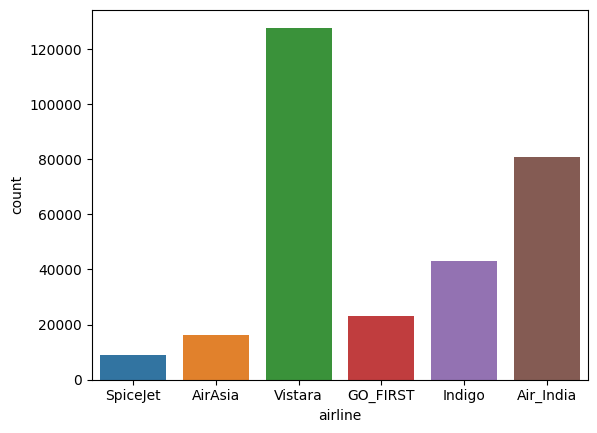

3484

In [10]:
fig = sns.countplot(df.airline)
plt.show(fig)
plt.close('all')
del fig
gc.collect()

Vistara is the most popular airline in India whereas SpiceJet is the least preferred airline among travellers.

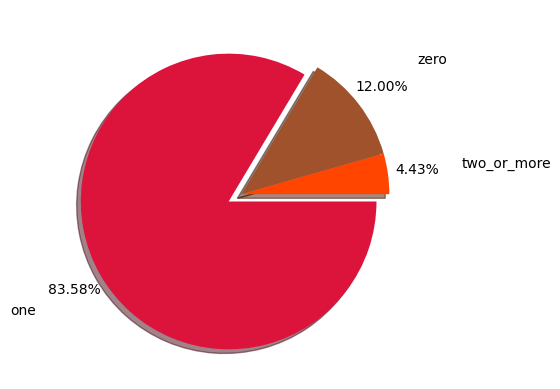

In [11]:
labels = df.stops.value_counts().keys()
values = df.stops.value_counts().values

plt.pie(values,
        labels=labels,
        explode=(0.1,0,0),
        shadow=True,
        autopct='%1.2f%%',
        pctdistance=1.2,
        labeldistance=1.5,
        radius=1,
        colors=['crimson','sienna','orangered'],
        counterclock=False)
plt.show();

A substantial number of flights had only one stop.

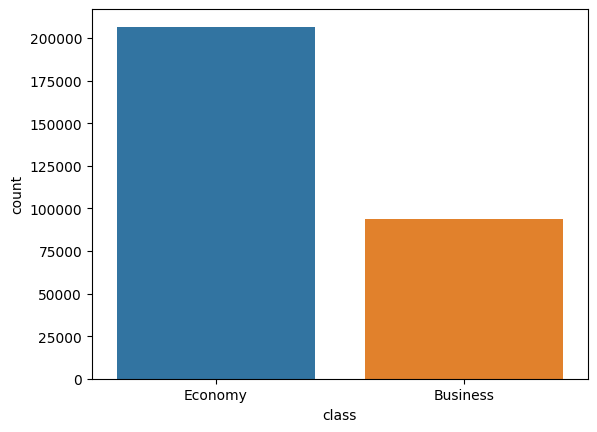

5806

In [12]:
fig = sns.countplot(df['class'])
plt.show(fig)
plt.close('all')
del fig
gc.collect()

Majority of the passengers travel through the Economy class.

In [13]:
src_city_cnts = df.source_city.value_counts()
src_city_cnts = pd.DataFrame(src_city_cnts).reset_index()
src_city_cnts.columns = ['city','count']
src_city_cnts

,city,count
0,Delhi,61343
1,Mumbai,60896
2,Bangalore,52061
3,Kolkata,46347
4,Hyderabad,40806
5,Chennai,38700


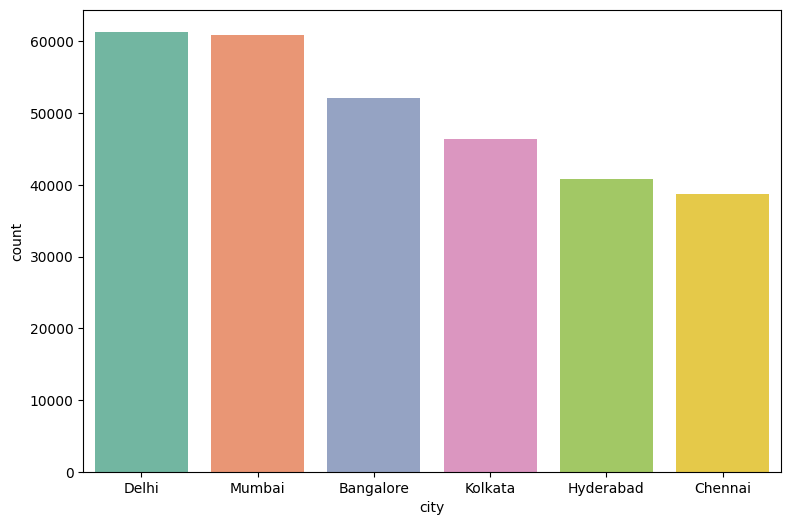

3899

In [14]:
plt.figure(figsize=(9,6))
fig = sns.barplot(x='city',y='count',data=src_city_cnts,palette='Set2')
plt.show(fig)
plt.close('all')
del fig
gc.collect()

Most of the flights originate from either Delhi or Mumbai.

In [15]:
dest_city_cnts = df.destination_city.value_counts()
dest_city_cnts = pd.DataFrame(dest_city_cnts).reset_index()
dest_city_cnts.columns = ['city','count']
dest_city_cnts

,city,count
0,Mumbai,59097
1,Delhi,57360
2,Bangalore,51068
3,Kolkata,49534
4,Hyderabad,42726
5,Chennai,40368


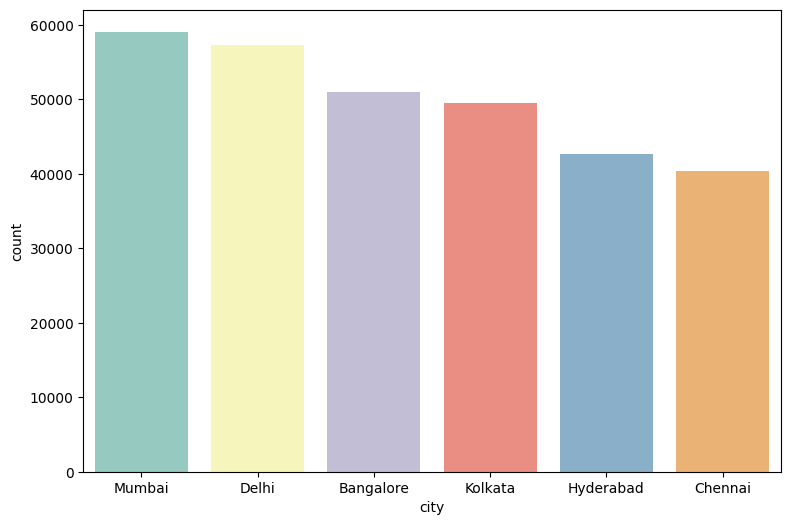

3883

In [16]:
plt.figure(figsize=(9,6))
fig = sns.barplot(x='city',y='count',data=dest_city_cnts,palette='Set3')
plt.show(fig)
plt.close('all')
del fig
gc.collect()

Likewise, Mumbai and Delhi are the most commonly visited cities in India with a considerable number of flights having either of these 2 cities as their destination.

Skewness of duration: 0.6028991297746269
Kurtosis of duration: -0.26899595805225696


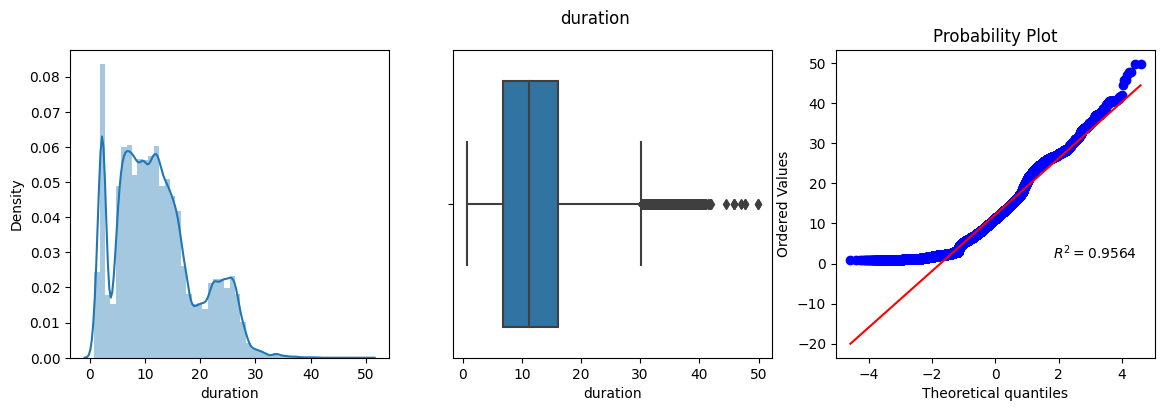

Skewness of days_left: -0.03546434955066582
Kurtosis of days_left: -1.156214725108152


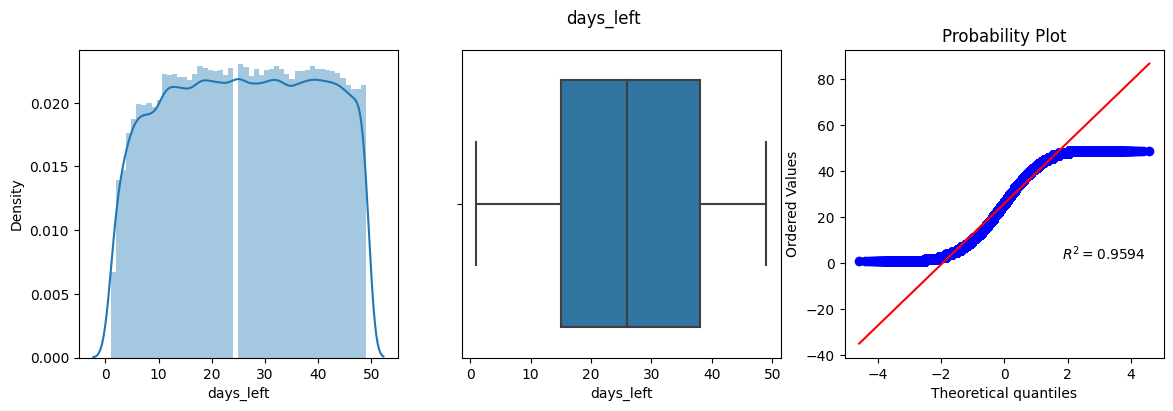

Skewness of price: 1.0613772532064343
Kurtosis of price: -0.3962927186960772


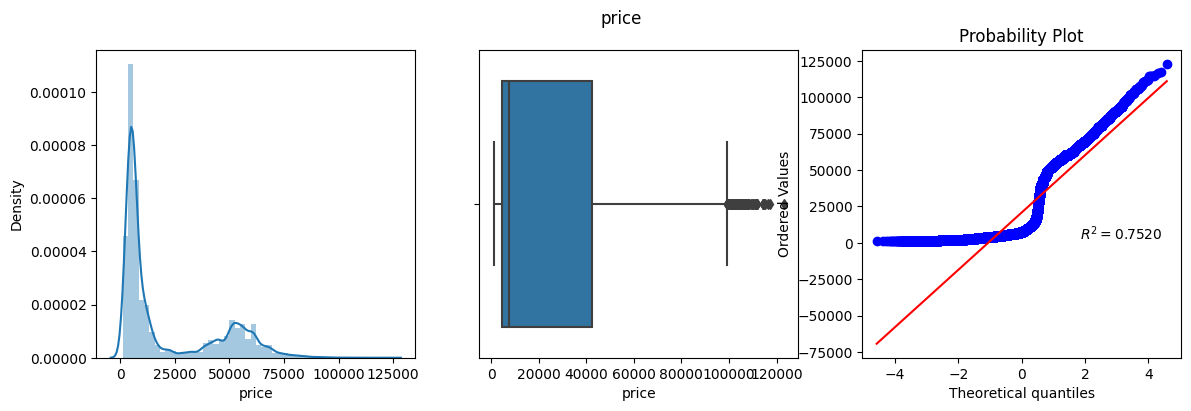

In [17]:
for col in df.select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],rvalue=True,dist='norm',plot=plt)
    plt.suptitle(col)
    plt.show()
    gc.collect()

In [18]:
skewed_cols = ['duration','price']

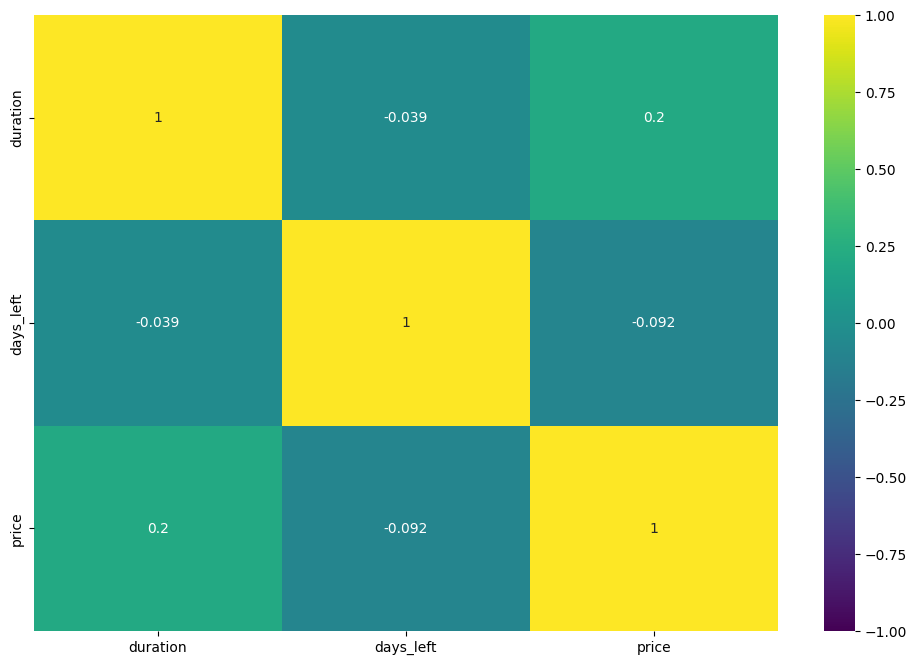

5780

In [19]:
plt.figure(figsize=(12,8))
fig = sns.heatmap(df.corr(),annot=True,cmap='viridis',vmin=-1.0,vmax=1.0)
plt.show(fig)
plt.close('all')
del fig
gc.collect()

<Figure size 1200x800 with 0 Axes>

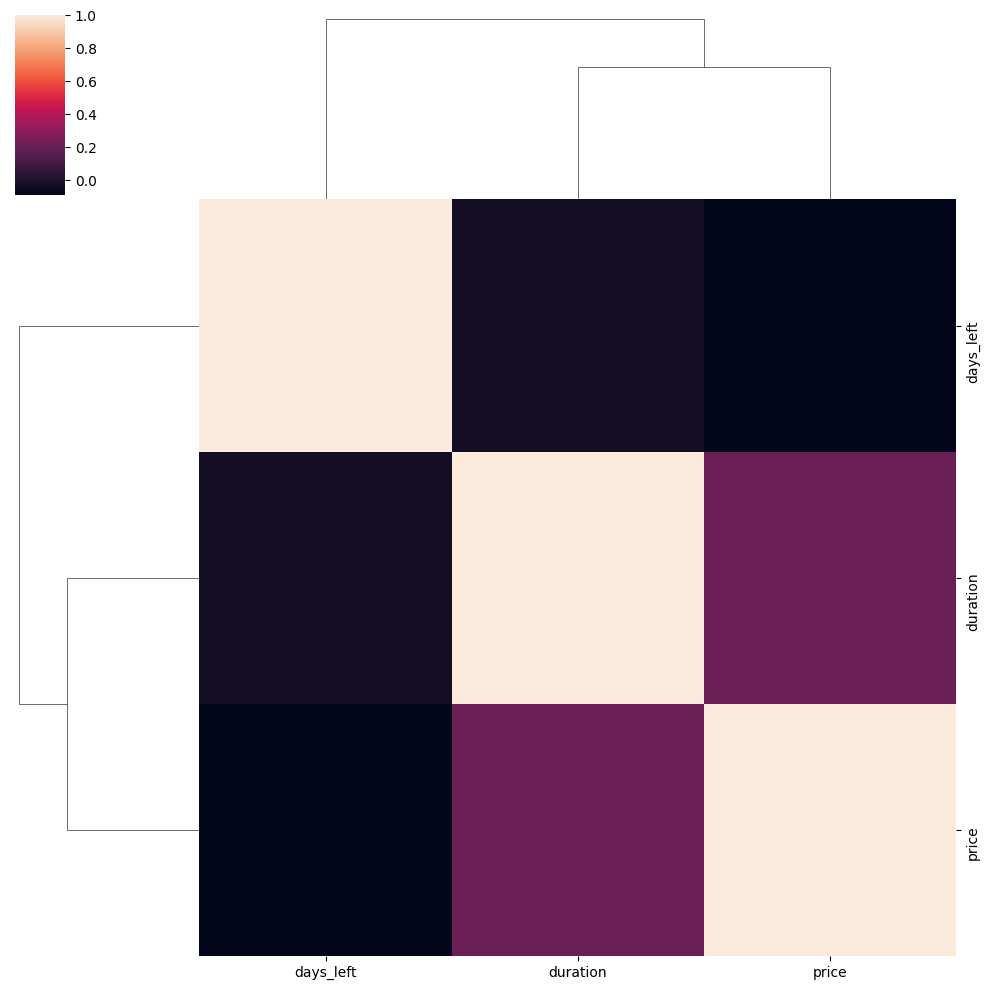

9989

In [20]:
plt.figure(figsize=(12,8))
fig = sns.clustermap(df.corr())
plt.show(fig)
plt.close('all')
del fig
gc.collect()

<Figure size 1200x800 with 0 Axes>

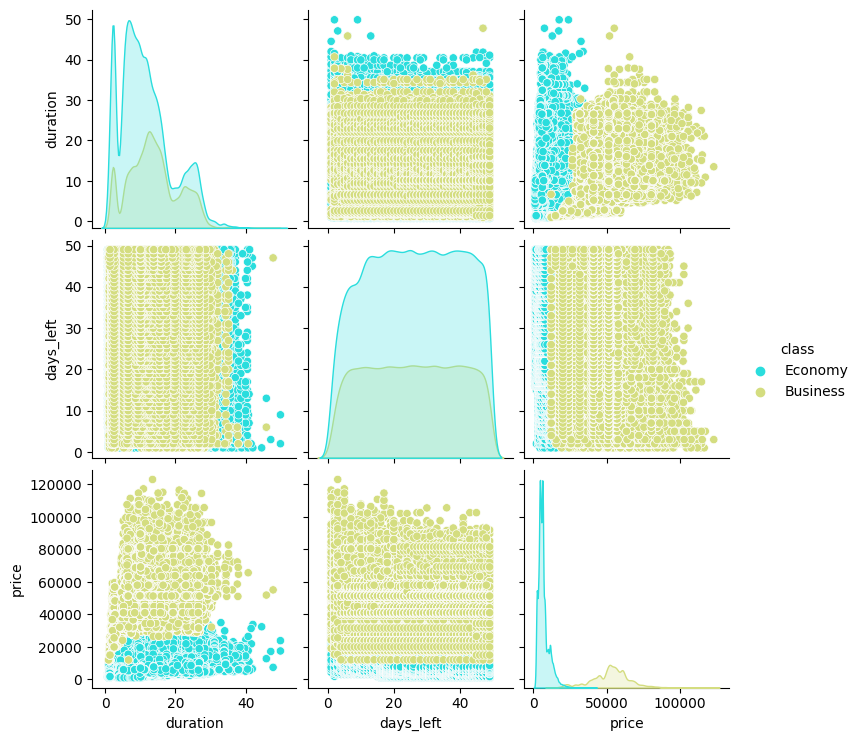

35706

In [21]:
plt.figure(figsize=(12,8))
fig = sns.pairplot(df,hue='class',palette='rainbow')
plt.show(fig)
plt.close('all')
del fig
gc.collect()

## Feature Engineering

### Categorical Encoding

In [22]:
src_city_encoder = OneHotEncoder(drop='first',sparse_output=False,max_categories=10,dtype=np.int64)
src_city_encoded = src_city_encoder.fit_transform(df[['source_city']])
src_city_encoded = pd.DataFrame(src_city_encoded,columns=src_city_encoder.get_feature_names_out())
src_city_encoded

,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
300148,1,0,0,0,0
300149,1,0,0,0,0
300150,1,0,0,0,0
300151,1,0,0,0,0


In [23]:
df = pd.concat([df,src_city_encoded],axis=1)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,0,1,0,0,0
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,0,1,0,0,0
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,0,1,0,0,0
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,0,1,0,0,0
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,0,1,0,0,0


In [24]:
dest_city_encoder = OneHotEncoder(drop='first',sparse_output=False,max_categories=10,dtype=np.int64)
dest_city_encoded = dest_city_encoder.fit_transform(df[['destination_city']])
dest_city_encoded = pd.DataFrame(dest_city_encoded,columns=dest_city_encoder.get_feature_names_out())
dest_city_encoded

,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
300148,0,0,1,0,0
300149,0,0,1,0,0
300150,0,0,1,0,0
300151,0,0,1,0,0


In [25]:
df = pd.concat([df,dest_city_encoded],axis=1)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,...,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,...,0,1,0,0,0,0,0,0,0,1
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,...,0,1,0,0,0,0,0,0,0,1
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,...,0,1,0,0,0,0,0,0,0,1
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,...,0,1,0,0,0,0,0,0,0,1
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,...,0,1,0,0,0,0,0,0,0,1


In [26]:
df.drop(['source_city','destination_city'],axis=1,inplace=True)

In [27]:
flight_encoder = OneHotEncoder(drop='first',sparse_output=False,dtype=np.int64,max_categories=10)
flights_encoded = flight_encoder.fit_transform(df[['flight']])
flights_encoded = pd.DataFrame(flights_encoded,columns=flight_encoder.get_feature_names_out())
flights_encoded.head()

,flight_UK-720,flight_UK-772,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_infrequent_sklearn
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


In [28]:
df = pd.concat([df,flights_encoded],axis=1)
df.head()

,airline,flight,departure_time,stops,arrival_time,class,duration,days_left,price,source_city_Chennai,...,destination_city_Mumbai,flight_UK-720,flight_UK-772,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_infrequent_sklearn
0,SpiceJet,SG-8709,Evening,zero,Night,Economy,2.17,1,5953,0,...,1,0,0,0,0,0,0,0,0,1
1,SpiceJet,SG-8157,Early_Morning,zero,Morning,Economy,2.33,1,5953,0,...,1,0,0,0,0,0,0,0,0,1
2,AirAsia,I5-764,Early_Morning,zero,Early_Morning,Economy,2.17,1,5956,0,...,1,0,0,0,0,0,0,0,0,1
3,Vistara,UK-995,Morning,zero,Afternoon,Economy,2.25,1,5955,0,...,1,0,0,0,0,0,0,0,0,1
4,Vistara,UK-963,Morning,zero,Morning,Economy,2.33,1,5955,0,...,1,0,0,0,0,0,0,0,0,1


In [29]:
df.rename({'flight_infrequent_sklearn': 'flight_other'},axis=1,inplace=True)

In [30]:
df.drop('flight',axis=1,inplace=True)

In [31]:
airline_encoder = OneHotEncoder(drop='first',sparse_output=False,dtype=np.int64,max_categories=10)
airlines_encoded = airline_encoder.fit_transform(df[['airline']])
airlines_encoded = pd.DataFrame(airlines_encoded,columns=airline_encoder.get_feature_names_out())
airlines_encoded.head()

,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [32]:
df = pd.concat([df,airlines_encoded],axis=1)
df.head()

,airline,departure_time,stops,arrival_time,class,duration,days_left,price,source_city_Chennai,source_city_Delhi,...,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_other,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,SpiceJet,Evening,zero,Night,Economy,2.17,1,5953,0,1,...,0,0,0,0,1,0,0,0,1,0
1,SpiceJet,Early_Morning,zero,Morning,Economy,2.33,1,5953,0,1,...,0,0,0,0,1,0,0,0,1,0
2,AirAsia,Early_Morning,zero,Early_Morning,Economy,2.17,1,5956,0,1,...,0,0,0,0,1,0,0,0,0,0
3,Vistara,Morning,zero,Afternoon,Economy,2.25,1,5955,0,1,...,0,0,0,0,1,0,0,0,0,1
4,Vistara,Morning,zero,Morning,Economy,2.33,1,5955,0,1,...,0,0,0,0,1,0,0,0,0,1


In [33]:
df.drop('airline',axis=1,inplace=True)

In [34]:
df.arrival_time.unique()

array(['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening',
       'Late_Night'], dtype=object)

In [35]:
df.departure_time.unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [36]:
df.stops.unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [37]:
df['class'].unique()

array(['Economy', 'Business'], dtype=object)

In [38]:
ohe = OrdinalEncoder(categories=[['zero','one','two_or_more'],['Early_Morning','Morning','Afternoon','Evening','Night','Late_Night'],['Early_Morning','Morning','Afternoon','Evening','Night','Late_Night'],['Economy','Business']])
df[['stops','arrival_time','departure_time','class']] = ohe.fit_transform(df[['stops','arrival_time','departure_time','class']])
df.head()

,departure_time,stops,arrival_time,class,duration,days_left,price,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,...,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_other,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,3.0,0.0,4.0,0.0,2.17,1,5953,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0.0,0.0,1.0,0.0,2.33,1,5953,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0.0,0.0,0.0,0.0,2.17,1,5956,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,0.0,2.0,0.0,2.25,1,5955,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,1.0,0.0,1.0,0.0,2.33,1,5955,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [39]:
ohe.categories_

[array(['zero', 'one', 'two_or_more'], dtype=object),
 array(['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night',
        'Late_Night'], dtype=object),
 array(['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night',
        'Late_Night'], dtype=object),
 array(['Economy', 'Business'], dtype=object)]

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   departure_time              300153 non-null  float64
 1   stops                       300153 non-null  float64
 2   arrival_time                300153 non-null  float64
 3   class                       300153 non-null  float64
 4   duration                    300153 non-null  float64
 5   days_left                   300153 non-null  int64  
 6   price                       300153 non-null  int64  
 7   source_city_Chennai         300153 non-null  int64  
 8   source_city_Delhi           300153 non-null  int64  
 9   source_city_Hyderabad       300153 non-null  int64  
 10  source_city_Kolkata         300153 non-null  int64  
 11  source_city_Mumbai          300153 non-null  int64  
 12  destination_city_Chennai    300153 non-null  int64  
 13  destination_ci

### Outlier Treatment

In [41]:
winsorizer = Winsorizer(capping_method='iqr',tail='both',fold=1.5)

for col in skewed_cols:
    df[col] = winsorizer.fit_transform(df[[col]])

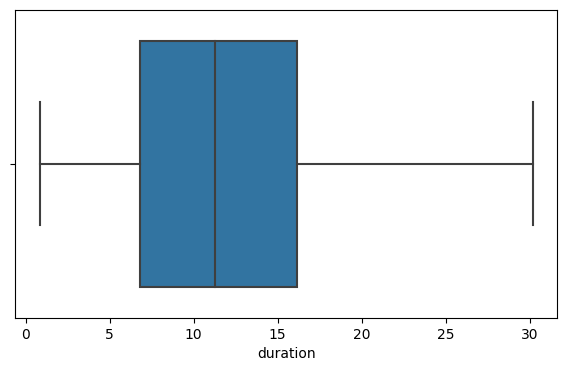

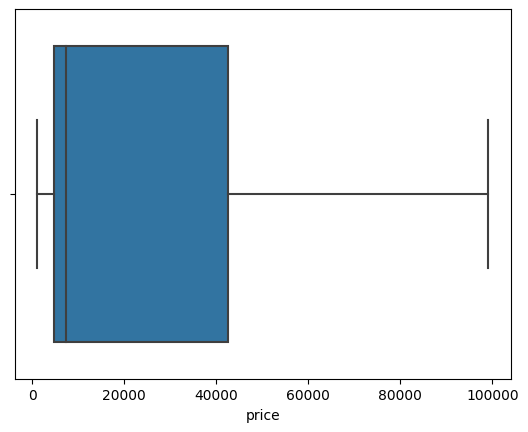

In [42]:
plt.figure(figsize=(7,4))

for col in skewed_cols:
    sns.boxplot(df[col])
    plt.show()

### Feature Splitting

In [43]:
X = df.drop('price',axis=1)
y = df.price

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=50,shuffle=True)

In [45]:
X_train.shape, X_test.shape

((210107, 30), (90046, 30))

In [46]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

### Feature Selection

In [47]:
kbest = SelectKBest(k=10,score_func=f_regression)
kbest.fit(X_train,y_train)

SelectKBest(score_func=<function f_regression at 0x00000259A5ED95A0>)

In [48]:
selected_features = kbest.get_feature_names_out()
selected_features

array(['stops', 'class', 'duration', 'days_left', 'flight_other',
       'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo',
       'airline_SpiceJet', 'airline_Vistara'], dtype=object)

In [49]:
perc = SelectPercentile(percentile=35,score_func=f_regression)
perc.fit(X_train,y_train)

SelectPercentile(percentile=35,
                 score_func=<function f_regression at 0x00000259A5ED95A0>)

In [50]:
selected_features = perc.get_feature_names_out()
selected_features

array(['stops', 'class', 'duration', 'days_left', 'flight_UK-772',
       'flight_other', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara'],
      dtype=object)

In [51]:
lasso = SelectFromModel(estimator=Lasso(),max_features=10)
lasso.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(), max_features=10)

In [52]:
selected_features = lasso.get_feature_names_out()
selected_features

array(['stops', 'class', 'flight_UK-822', 'flight_UK-826',
       'flight_UK-828', 'flight_UK-874', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara'],
      dtype=object)

In [53]:
rf = SelectFromModel(estimator=RandomForestRegressor(),max_features=10)
rf.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestRegressor(), max_features=10)

In [54]:
selected_features = rf.get_feature_names_out()
selected_features

array(['class', 'duration'], dtype=object)

In [55]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
def plot_feature_importances(feat_imp_type):
    feat_imps = xgb.get_booster().get_score(importance_type=feat_imp_type)
    keys = list(feat_imps.keys())
    values = list(feat_imps.values())
    feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"]).sort_values(by="Importance", ascending=False).reset_index()
    feat_imps_df.rename({'index': 'Feature'},axis=1,inplace=True)
    fig = sns.barplot(x='Importance',y='Feature',data=feat_imps_df,orient='horizontal',palette='viridis')
    plt.title(f"{feat_imp_type.title()} Feature Importance")
    plt.show(fig)
    plt.close('all')
    del fig
    gc.collect();

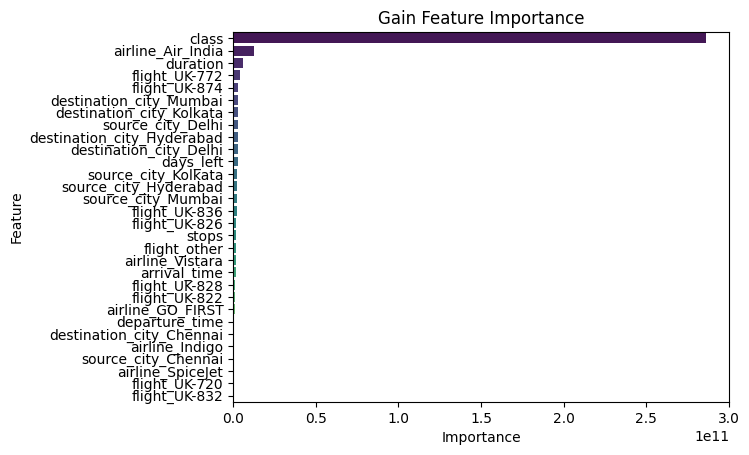

In [57]:
plot_feature_importances('gain')

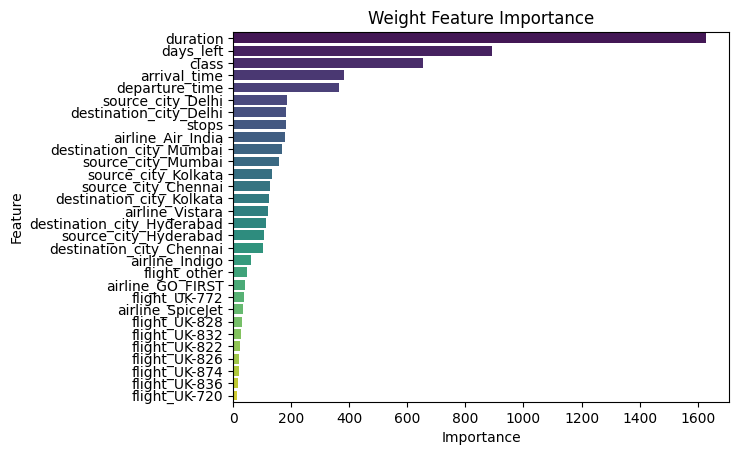

In [58]:
plot_feature_importances('weight')

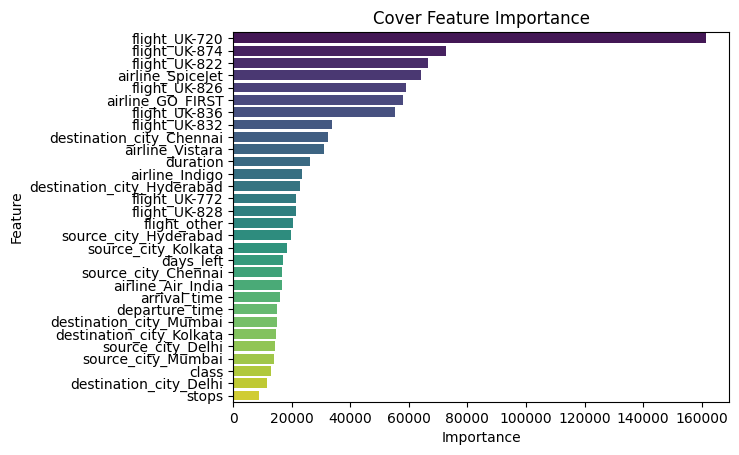

In [59]:
plot_feature_importances('cover')

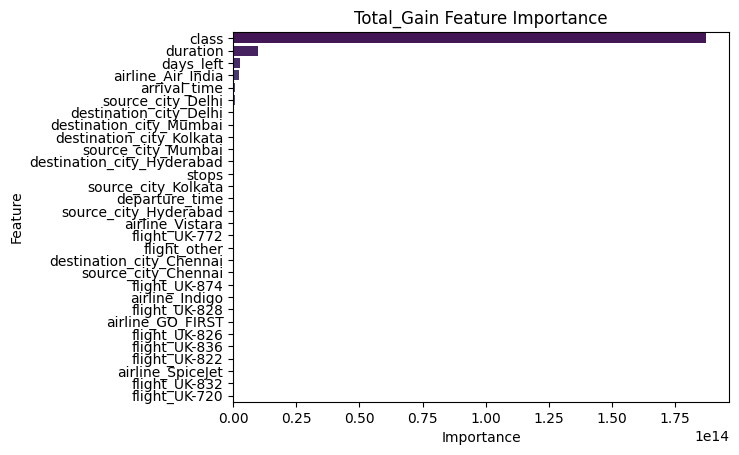

In [60]:
plot_feature_importances('total_gain')

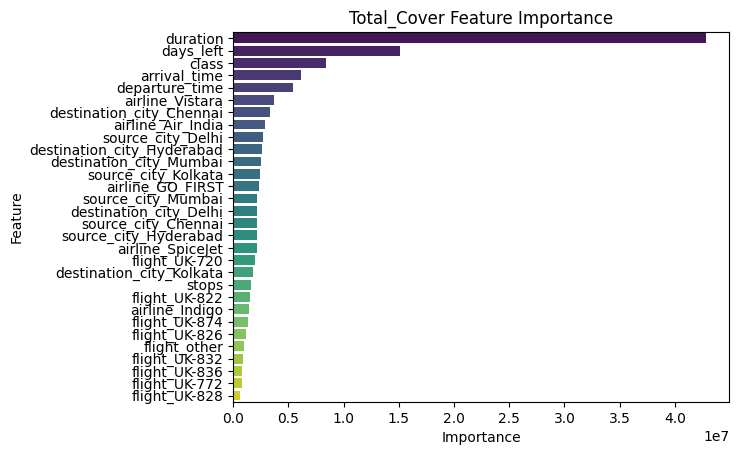

In [61]:
plot_feature_importances('total_cover')

In [62]:
final_selected_features = ['stops',
                           'class',
                           'duration',
                           'days_left',
                           'airline_Air_India', 
                           'airline_GO_FIRST',
                           'airline_Indigo', 
                           'airline_SpiceJet', 
                           'airline_Vistara',
                           'flight_UK-720',
                           'flight_UK-822',
                           'flight_UK-826',
                           'flight_UK-828', 
                           'flight_UK-874',
                           'arrival_time',
                           'departure_time']
len(final_selected_features)

16

In [63]:
final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]
gc.collect()

0

In [64]:
del xgb
gc.collect()

0

### Feature Scaling

In [65]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_UK-720,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-874,arrival_time,departure_time
0,0.191949,1.487315,-0.330549,0.072377,-0.607217,-0.289110,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,-0.611801
1,0.191949,-0.672353,-1.019531,-0.296257,-0.607217,-0.289110,2.442530,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,0.801078
2,0.191949,-0.672353,-0.797822,-0.738617,-0.607217,3.458897,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-0.517527,-0.611801
3,0.191949,-0.672353,0.629254,1.104552,1.646857,-0.289110,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-1.257466,0.801078
4,0.191949,1.487315,-0.236534,-1.033524,-0.607217,-0.289110,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,-0.611801


In [66]:
final_X_test.head()

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_UK-720,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-874,arrival_time,departure_time
0,0.191949,1.487315,-0.295469,1.030825,-0.607217,-0.28911,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,-0.611801
1,0.191949,-0.672353,-1.218789,-0.148803,-0.607217,-0.28911,2.442530,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-1.257466,-1.318241
2,0.191949,-0.672353,1.587655,-1.697065,1.646857,-0.28911,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.222411,0.801078
3,0.191949,1.487315,-0.271614,1.473186,1.646857,-0.28911,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,0.094638
4,0.191949,1.487315,0.208288,0.883372,-0.607217,-0.28911,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-1.257466,0.801078


## Model Training & Evaluation

In [67]:
models = []
r2_scores = []
mape_scores = []
rmse_scores = []

In [68]:
final_X_train.drop(final_X_train.columns[final_X_train.columns.duplicated()],axis=1,inplace=True)
final_X_test.drop(final_X_test.columns[final_X_test.columns.duplicated()],axis=1,inplace=True)

In [69]:
def train_and_evaluate_model(model):
    model.fit(final_X_train,y_train)
    y_pred = model.predict(final_X_test)
    r2 = r2_score(y_test,y_pred)
    rmse = mean_squared_error(y_test,y_pred,squared=False)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    print("R2 Score:",r2)
    print("RMSE:",rmse)
    print("MAPE:",mape)
    models.append(model)
    r2_scores.append(r2)
    mape_scores.append(mape)
    rmse_scores.append(rmse)
    gc.collect()

In [70]:
train_and_evaluate_model(LinearRegression())

R2 Score: 0.9087752184521475
RMSE: 6859.898457588487
MAPE: 0.4238229922723229


In [71]:
train_and_evaluate_model(SGDRegressor())

R2 Score: 0.9085504360970852
RMSE: 6868.344821569319
MAPE: 0.41532798536954185


In [72]:
train_and_evaluate_model(PassiveAggressiveRegressor())

R2 Score: 0.901341551720158
RMSE: 7133.922900566816
MAPE: 0.2919872325095318


In [73]:
train_and_evaluate_model(Lasso())

R2 Score: 0.9087747131726956
RMSE: 6859.917455501519
MAPE: 0.4238230871509927


In [74]:
train_and_evaluate_model(Ridge())

R2 Score: 0.9087751998991571
RMSE: 6859.899155160032
MAPE: 0.42382230386842296


In [75]:
train_and_evaluate_model(ElasticNet())

R2 Score: 0.8109003746374702
RMSE: 9876.580444012436
MAPE: 0.7759079199117127


In [76]:
train_and_evaluate_model(BayesianRidge())

R2 Score: 0.9087751869689312
RMSE: 6859.899641321922
MAPE: 0.42382182520386374


In [77]:
train_and_evaluate_model(ARDRegression())

R2 Score: 0.9087751785565682
RMSE: 6859.899957617252
MAPE: 0.4238792610135485


In [78]:
train_and_evaluate_model(RANSACRegressor())

R2 Score: 0.8976132279817016
RMSE: 7267.469146758569
MAPE: 0.2875893483830217


In [79]:
train_and_evaluate_model(PoissonRegressor())

R2 Score: 0.9249181593014218
RMSE: 6223.414490893003
MAPE: 0.31403777883116757


In [80]:
train_and_evaluate_model(TweedieRegressor())

R2 Score: 0.7009026030806478
RMSE: 12421.315353423433
MAPE: 1.0850216290319485


In [81]:
train_and_evaluate_model(HuberRegressor())

R2 Score: 0.9026466619750133
RMSE: 7086.580008007577
MAPE: 0.30078467602415754


In [82]:
train_and_evaluate_model(KNeighborsRegressor())

R2 Score: 0.9475954783284615
RMSE: 5199.309275950753
MAPE: 0.19767013317759036


In [83]:
train_and_evaluate_model(LinearSVR())

R2 Score: 0.8983853860285882
RMSE: 7240.013182944752
MAPE: 0.28734085141793647


In [84]:
train_and_evaluate_model(DecisionTreeRegressor())

R2 Score: 0.9454265969244104
RMSE: 5305.811165119045
MAPE: 0.16977200808538606


In [85]:
train_and_evaluate_model(ExtraTreesRegressor())

R2 Score: 0.9496602357941563
RMSE: 5095.852627116095
MAPE: 0.17992075466493954


In [86]:
train_and_evaluate_model(RandomForestRegressor())

R2 Score: 0.956335878369197
RMSE: 4745.95520967202
MAPE: 0.16524501290210383


In [87]:
train_and_evaluate_model(GradientBoostingRegressor())

R2 Score: 0.9488792782189982
RMSE: 5135.228342974621
MAPE: 0.22125626108833968


In [88]:
train_and_evaluate_model(AdaBoostRegressor())

R2 Score: 0.9346098480631961
RMSE: 5807.877456735347
MAPE: 0.29819940474257045


In [89]:
train_and_evaluate_model(BaggingRegressor())

R2 Score: 0.9586430726538551
RMSE: 4618.866433062498
MAPE: 0.15784298156439364


In [90]:
train_and_evaluate_model(HistGradientBoostingRegressor())

R2 Score: 0.9586203245657664
RMSE: 4620.136545990321
MAPE: 0.1979063576262867


In [91]:
train_and_evaluate_model(MLPRegressor())

R2 Score: 0.9443424454015035
RMSE: 5358.254429720311
MAPE: 0.23008333872104983


In [92]:
train_and_evaluate_model(VotingRegressor(estimators=[
    ('BAG',BaggingRegressor()),
    ('HGB',HistGradientBoostingRegressor()),
    ('GB',GradientBoostingRegressor()),
    ('RF',RandomForestRegressor()),
    ('ET',ExtraTreesRegressor())
],verbose=2,n_jobs=10))

R2 Score: 0.9626988201122599
RMSE: 4386.544665200866
MAPE: 0.17134788948361007


In [93]:
train_and_evaluate_model(StackingRegressor(estimators=[
    ('HGB',HistGradientBoostingRegressor()),
    ('BAG',BaggingRegressor()),
    ('RF',RandomForestRegressor())
],final_estimator=ExtraTreesRegressor(),verbose=2,n_jobs=10))

R2 Score: 0.9631375246475538
RMSE: 4360.672979067413
MAPE: 0.16727743979739595


In [94]:
train_and_evaluate_model(XGBRegressor())

R2 Score: 0.9646997023974598
RMSE: 4267.273262194596
MAPE: 0.17789751957117136


In [95]:
train_and_evaluate_model(XGBRFRegressor())

R2 Score: 0.9462252802200186
RMSE: 5266.842715384235
MAPE: 0.21730997397935808


In [96]:
train_and_evaluate_model(CatBoostRegressor(silent=True))

R2 Score: 0.9627128352223667
RMSE: 4385.720513223777
MAPE: 0.18230603609011625


In [97]:
train_and_evaluate_model(LGBMRegressor())

R2 Score: 0.9584764164311413
RMSE: 4628.163411362634
MAPE: 0.196797932949456


## Baseline Models Performance Comparison

In [98]:
model_perfs = pd.DataFrame({'model': models, 'r2': r2_scores, 'rmse': rmse_scores, 'mape': mape_scores}).sort_values('r2',ascending=False).reset_index()
model_perfs

,index,model,r2,rmse,mape
0,24,"XGBRegressor(base_score=None, booster=None, ca...",0.964700,4267.273262,0.177898
1,23,"StackingRegressor(estimators=[('HGB', HistGrad...",0.963138,4360.672979,0.167277
2,26,<catboost.core.CatBoostRegressor object at 0x0...,0.962713,4385.720513,0.182306
3,22,"VotingRegressor(estimators=[('BAG', BaggingReg...",0.962699,4386.544665,0.171348
4,19,(DecisionTreeRegressor(random_state=1345784261...,0.958643,4618.866433,0.157843
5,20,HistGradientBoostingRegressor(),0.958620,4620.136546,0.197906
6,27,LGBMRegressor(),0.958476,4628.163411,0.196798
7,16,"(DecisionTreeRegressor(max_features='auto', ra...",0.956336,4745.955210,0.165245
8,15,"(ExtraTreeRegressor(random_state=714472269), E...",0.949660,5095.852627,0.179921
9,17,([DecisionTreeRegressor(criterion='friedman_ms...,0.948879,5135.228343,0.221256


## Hyperparameter Tuning & Cross Validation

In [99]:
param_grid = {'n_neighbors': [2,8,12,20],
              'weights': ['uniform','distance'],
              'algorithm': ['ball_tree', 'brute'],
              'metric': ['minkowski','manhattan','euclidean','chebyshev'],
              'p': [1,2]
             }

grid_knn = RandomizedSearchCV(KNeighborsRegressor(),param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_knn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=8, p=2, weights=uniform; total time=  10.3s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=8, p=2, weights=uniform; total time=  11.3s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=8, p=2, weights=uniform; total time=  11.5s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=8, p=2, weights=uniform; total time=  11.4s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=8, p=2, weights=uniform; total time=  11.3s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=20, p=1, weights=distance; total time=  40.8s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=20, p=1, weights=distance; total time=  40.3s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=20, p=1, weights=distance; total time=  40.7s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=20, p=1, weights=distance; total time=  4

In [100]:
grid_knn.best_params_

{'weights': 'uniform',
 'p': 1,
 'n_neighbors': 20,
 'metric': 'minkowski',
 'algorithm': 'ball_tree'}

In [101]:
grid_knn.best_score_

0.9507098748181777

In [102]:
param_grid = {'learning_rate': [0.2,0.4,0.5,0.8,1.0],
              'loss': ['squared_error','absolute_error','poisson','quantile'],
              'max_bins': np.arange(0,255,50),
              'interaction_cst': ['pairwise','no_interaction']}

grid_hgb = RandomizedSearchCV(HistGradientBoostingRegressor(),param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_hgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=squared_error, max_bins=150; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=squared_error, max_bins=150; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=squared_error, max_bins=150; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=squared_error, max_bins=150; total time=   0.0s
[CV] END interaction_cst=no_interaction, learning_rate=1.0, loss=squared_error, max_bins=150; total time=   0.0s
[CV] END interaction_cst=pairwise, learning_rate=1.0, loss=poisson, max_bins=250; total time=   3.7s
[CV] END interaction_cst=pairwise, learning_rate=1.0, loss=poisson, max_bins=250; total time=   3.3s
[CV] END interaction_cst=pairwise, learning_rate=1.0, loss=poisson, max_bins=250; total time=   3.4s
[CV] END interaction_cst=pairwise, learning_rate=1.0, loss=poisson, max

In [103]:
grid_hgb.best_score_

0.9608274045637681

In [104]:
grid_hgb.best_params_

{'max_bins': 250,
 'loss': 'poisson',
 'learning_rate': 1.0,
 'interaction_cst': 'pairwise'}

In [105]:
param_grid = {'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
             'C': [0.0001,0.001,0.01,0.1,1],
             'epsilon': np.linspace(0.001,1,5)}

grid_lsvr = RandomizedSearchCV(LinearSVR(),param_grid,cv=5,verbose=2,n_jobs=10)
train_and_evaluate_model(grid_lsvr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
R2 Score: 0.9087739480445484
RMSE: 6859.946223319689
MAPE: 0.42369134062143887


In [106]:
grid_lsvr.best_score_

0.9066077972205966

In [107]:
grid_lsvr.best_params_

{'loss': 'squared_epsilon_insensitive', 'epsilon': 0.5005, 'C': 0.01}

In [108]:
param_grid = {'criterion': ['squared_error','friedman_mse','poisson'],
              'splitter': ['best','random'],
              'max_features': ['sqrt','log2']
             }

grid_dt = RandomizedSearchCV(DecisionTreeRegressor(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_dt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=squared_error, max_features=sqrt, splitter=best; total time=   1.0s
[CV] END criterion=squared_error, max_features=sqrt, splitter=best; total time=   0.8s
[CV] END criterion=squared_error, max_features=sqrt, splitter=best; total time=   0.7s
[CV] END criterion=squared_error, max_features=sqrt, splitter=best; total time=   0.9s
[CV] END criterion=squared_error, max_features=sqrt, splitter=best; total time=   1.0s
[CV] END criterion=squared_error, max_features=log2, splitter=random; total time=   0.6s
[CV] END criterion=squared_error, max_features=log2, splitter=random; total time=   0.7s
[CV] END criterion=squared_error, max_features=log2, splitter=random; total time=   0.7s
[CV] END criterion=squared_error, max_features=log2, splitter=random; total time=   0.7s
[CV] END criterion=squared_error, max_features=log2, splitter=random; total time=   0.5s
[CV] END criterion=friedman_mse, max_features=sqrt, splitte

In [109]:
grid_dt.best_score_

0.9346213744405963

In [110]:
grid_dt.best_params_

{'splitter': 'best', 'max_features': 'log2', 'criterion': 'poisson'}

In [111]:
param_grid =  {'loss': ['squared_error','huber','quantile'],
                'n_estimators': [100,400,700,1000],
                'learning_rate': [0.2,0.4,0.7,1],
                'criterion': ['friedman_mse','squared_error'],
                'max_features': ['sqrt','log2']
                }
    
grid_gb = RandomizedSearchCV(GradientBoostingRegressor(),param_grid,verbose=4,cv=5)
train_and_evaluate_model(grid_gb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=friedman_mse, learning_rate=1, loss=huber, max_features=sqrt, n_estimators=400;, score=0.951 total time= 1.6min
[CV 2/5] END criterion=friedman_mse, learning_rate=1, loss=huber, max_features=sqrt, n_estimators=400;, score=0.952 total time= 1.6min
[CV 3/5] END criterion=friedman_mse, learning_rate=1, loss=huber, max_features=sqrt, n_estimators=400;, score=0.951 total time= 1.6min
[CV 4/5] END criterion=friedman_mse, learning_rate=1, loss=huber, max_features=sqrt, n_estimators=400;, score=0.953 total time= 1.7min
[CV 5/5] END criterion=friedman_mse, learning_rate=1, loss=huber, max_features=sqrt, n_estimators=400;, score=0.951 total time= 1.7min
[CV 1/5] END criterion=friedman_mse, learning_rate=0.2, loss=huber, max_features=sqrt, n_estimators=700;, score=0.950 total time= 2.8min
[CV 2/5] END criterion=friedman_mse, learning_rate=0.2, loss=huber, max_features=sqrt, n_estimators=700;, score=0.951 total tim

In [112]:
grid_gb.best_score_

0.9557670834685347

In [113]:
grid_gb.best_params_

{'n_estimators': 1000,
 'max_features': 'log2',
 'loss': 'squared_error',
 'learning_rate': 1,
 'criterion': 'squared_error'}

In [114]:
 param_grid = {'learning_rate': [0.2,0.4,0.5,0.7,1],
'n_estimators': [100,400,700,800,1000]
}
    
grid_cat = RandomizedSearchCV(CatBoostRegressor(silent=True),param_grid,verbose=5,cv=5)
train_and_evaluate_model(grid_cat)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.5, n_estimators=700;, score=0.967 total time=  17.5s
[CV 2/5] END learning_rate=0.5, n_estimators=700;, score=0.968 total time=  16.8s
[CV 3/5] END learning_rate=0.5, n_estimators=700;, score=0.968 total time=  16.3s
[CV 4/5] END learning_rate=0.5, n_estimators=700;, score=0.968 total time=  17.2s
[CV 5/5] END learning_rate=0.5, n_estimators=700;, score=0.967 total time=  17.3s
[CV 1/5] END learning_rate=0.2, n_estimators=700;, score=0.963 total time=  17.4s
[CV 2/5] END learning_rate=0.2, n_estimators=700;, score=0.963 total time=  17.5s
[CV 3/5] END learning_rate=0.2, n_estimators=700;, score=0.963 total time=  17.3s
[CV 4/5] END learning_rate=0.2, n_estimators=700;, score=0.963 total time=  17.5s
[CV 5/5] END learning_rate=0.2, n_estimators=700;, score=0.964 total time=  17.2s
[CV 1/5] END learning_rate=0.7, n_estimators=700;, score=0.968 total time=  15.9s
[CV 2/5] END learning_rate=0.7, n_est

In [115]:
grid_cat.best_score_

0.9688868010910291

In [116]:
grid_cat.best_params_

{'n_estimators': 1000, 'learning_rate': 0.7}

In [117]:
param_grid = {'boosting_type': ['gbdt','dart','goss','rf'],
            'learning_rate': np.linspace(0,1,6)[1:],
            'n_estimators': [100,300,500,800,1000],
            'importance_type': ['split','gain'],
            'min_split_gain': [0.68,0.79,0.87,1]}

grid_lgbm = RandomizedSearchCV(LGBMRegressor(),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_lgbm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END boosting_type=goss, importance_type=split, learning_rate=0.6000000000000001, min_split_gain=0.79, n_estimators=500;, score=0.965 total time=   5.5s
[CV 2/5] END boosting_type=goss, importance_type=split, learning_rate=0.6000000000000001, min_split_gain=0.79, n_estimators=500;, score=0.965 total time=   5.6s
[CV 3/5] END boosting_type=goss, importance_type=split, learning_rate=0.6000000000000001, min_split_gain=0.79, n_estimators=500;, score=0.965 total time=   5.6s
[CV 4/5] END boosting_type=goss, importance_type=split, learning_rate=0.6000000000000001, min_split_gain=0.79, n_estimators=500;, score=0.965 total time=   8.4s
[CV 5/5] END boosting_type=goss, importance_type=split, learning_rate=0.6000000000000001, min_split_gain=0.79, n_estimators=500;, score=0.965 total time=   9.3s
[CV 1/5] END boosting_type=goss, importance_type=split, learning_rate=0.4, min_split_gain=0.68, n_estimators=800;, score=0.966 total t

In [118]:
grid_lgbm.best_score_

0.9677463589096374

In [119]:
grid_lgbm.best_params_

{'n_estimators': 800,
 'min_split_gain': 0.68,
 'learning_rate': 0.6000000000000001,
 'importance_type': 'split',
 'boosting_type': 'dart'}

In [120]:
param_grid = {'n_estimators': [100,400,700,1000],
        'grow_policy': [0,1],
        'learning_rate': [0.1,0.4,0.7,1],
        'booster': ['gbtree','gblinear','dart'],
        'sampling_method': ['uniform','gradient_based'],
        'importance_type': ['gain','weight','cover','total_gain','total_cover']
}

grid_xgb = RandomizedSearchCV(XGBRegressor(),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_xgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END booster=dart, grow_policy=1, importance_type=total_gain, learning_rate=1, n_estimators=400, sampling_method=uniform;, score=nan total time=   1.0s
[CV 2/5] END booster=dart, grow_policy=1, importance_type=total_gain, learning_rate=1, n_estimators=400, sampling_method=uniform;, score=nan total time=   0.0s
[CV 3/5] END booster=dart, grow_policy=1, importance_type=total_gain, learning_rate=1, n_estimators=400, sampling_method=uniform;, score=nan total time=   0.0s
[CV 4/5] END booster=dart, grow_policy=1, importance_type=total_gain, learning_rate=1, n_estimators=400, sampling_method=uniform;, score=nan total time=   0.0s
[CV 5/5] END booster=dart, grow_policy=1, importance_type=total_gain, learning_rate=1, n_estimators=400, sampling_method=uniform;, score=nan total time=   0.0s
[23:48:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "grow_policy", "sampling_

[CV 5/5] END booster=gblinear, grow_policy=0, importance_type=total_gain, learning_rate=0.4, n_estimators=100, sampling_method=uniform;, score=0.907 total time=   1.6s
[23:49:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "grow_policy", "sampling_method" } are not used.

[CV 1/5] END booster=gblinear, grow_policy=1, importance_type=total_cover, learning_rate=1, n_estimators=400, sampling_method=gradient_based;, score=0.906 total time=   5.8s
[23:49:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "grow_policy", "sampling_method" } are not used.

[CV 2/5] END booster=gblinear, grow_policy=1, importance_type=total_cover, learning_rate=1, n_estimators=400, sampling_method=gradient_based;, score=0.906 total time=   6.2s
[23:49:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "grow_policy", "sampling_method" } are not

In [121]:
grid_xgb.best_score_

0.9066079820023288

In [122]:
grid_xgb.best_params_

{'sampling_method': 'uniform',
 'n_estimators': 100,
 'learning_rate': 0.4,
 'importance_type': 'total_cover',
 'grow_policy': 1,
 'booster': 'gblinear'}

In [123]:
param_grid = {'loss': ['squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive'],
'penalty': ['l2', 'l1', 'elasticnet'],
'l1_ratio': [0.15,0.45,0.68,0.81,0.97],
'alpha': [0.0001,0.001,0.01,0.1,1],
'shuffle': [True,False],
'learning_rate': ['adaptive','constant','optimal','invscaling'],
'epsilon': np.linspace(0.001,100,10),
'average': [True,False]
}

grid_sgd = RandomizedSearchCV(SGDRegressor(),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_sgd)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=1, average=True, epsilon=100.0, l1_ratio=0.45, learning_rate=optimal, loss=squared_error, penalty=l2, shuffle=True;, score=0.699 total time=   0.7s
[CV 2/5] END alpha=1, average=True, epsilon=100.0, l1_ratio=0.45, learning_rate=optimal, loss=squared_error, penalty=l2, shuffle=True;, score=0.700 total time=   0.6s
[CV 3/5] END alpha=1, average=True, epsilon=100.0, l1_ratio=0.45, learning_rate=optimal, loss=squared_error, penalty=l2, shuffle=True;, score=0.700 total time=   0.4s
[CV 4/5] END alpha=1, average=True, epsilon=100.0, l1_ratio=0.45, learning_rate=optimal, loss=squared_error, penalty=l2, shuffle=True;, score=0.701 total time=   0.4s
[CV 5/5] END alpha=1, average=True, epsilon=100.0, l1_ratio=0.45, learning_rate=optimal, loss=squared_error, penalty=l2, shuffle=True;, score=0.699 total time=   0.6s
[CV 1/5] END alpha=0.1, average=True, epsilon=55.55599999999999, l1_ratio=0.45, learning_rate=optimal, l

[CV 4/5] END alpha=0.1, average=True, epsilon=66.667, l1_ratio=0.68, learning_rate=invscaling, loss=huber, penalty=l2, shuffle=False;, score=-0.279 total time=  15.9s
[CV 5/5] END alpha=0.1, average=True, epsilon=66.667, l1_ratio=0.68, learning_rate=invscaling, loss=huber, penalty=l2, shuffle=False;, score=-0.292 total time=  15.4s
[CV 1/5] END alpha=0.01, average=False, epsilon=0.001, l1_ratio=0.97, learning_rate=optimal, loss=epsilon_insensitive, penalty=elasticnet, shuffle=True;, score=-0.718 total time= 1.2min
[CV 2/5] END alpha=0.01, average=False, epsilon=0.001, l1_ratio=0.97, learning_rate=optimal, loss=epsilon_insensitive, penalty=elasticnet, shuffle=True;, score=-0.727 total time= 1.3min
[CV 3/5] END alpha=0.01, average=False, epsilon=0.001, l1_ratio=0.97, learning_rate=optimal, loss=epsilon_insensitive, penalty=elasticnet, shuffle=True;, score=-0.728 total time= 1.3min
[CV 4/5] END alpha=0.01, average=False, epsilon=0.001, l1_ratio=0.97, learning_rate=optimal, loss=epsilon_in

In [124]:
grid_sgd.best_score_

0.9066066376263576

In [125]:
grid_sgd.best_params_

{'shuffle': True,
 'penalty': 'elasticnet',
 'loss': 'squared_epsilon_insensitive',
 'learning_rate': 'adaptive',
 'l1_ratio': 0.81,
 'epsilon': 66.667,
 'average': False,
 'alpha': 0.001}

In [126]:
param_grid = {'epsilon': np.linspace(1,10,10),
'alpha': np.linspace(0.0001,10,10)}

grid_huber = RandomizedSearchCV(HuberRegressor(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_huber)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................alpha=1.1112, epsilon=7.0; total time=   1.4s
[CV] END ..........................alpha=1.1112, epsilon=7.0; total time=   1.3s
[CV] END ..........................alpha=1.1112, epsilon=7.0; total time=   1.5s
[CV] END ..........................alpha=1.1112, epsilon=7.0; total time=   1.5s
[CV] END ..........................alpha=1.1112, epsilon=7.0; total time=   1.4s
[CV] END ..........................alpha=6.6667, epsilon=8.0; total time=   1.1s
[CV] END ..........................alpha=6.6667, epsilon=8.0; total time=   1.1s
[CV] END ..........................alpha=6.6667, epsilon=8.0; total time=   1.2s
[CV] END ..........................alpha=6.6667, epsilon=8.0; total time=   1.2s
[CV] END ..........................alpha=6.6667, epsilon=8.0; total time=   1.2s
[CV] END ..........................alpha=3.3334, epsilon=6.0; total time=   1.6s
[CV] END ..........................alpha=3.3334,

In [127]:
grid_huber.best_score_

0.9045413571184338

In [128]:
grid_huber.best_params_

{'epsilon': 7.0, 'alpha': 1.1112}

In [129]:
param_grid = {'link': ['auto', 'identity', 'log'],
'solver': ['lbfgs', 'newton-cholesky'],
'alpha': np.linspace(0.0001,10,10)}

grid_tweedie = RandomizedSearchCV(TweedieRegressor(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_tweedie)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............alpha=4.4445, link=log, solver=lbfgs; total time=   0.8s
[CV] END ...............alpha=4.4445, link=log, solver=lbfgs; total time=   0.6s
[CV] END ...............alpha=4.4445, link=log, solver=lbfgs; total time=   0.6s
[CV] END ...............alpha=4.4445, link=log, solver=lbfgs; total time=   0.6s
[CV] END ...............alpha=4.4445, link=log, solver=lbfgs; total time=   0.6s
[CV] END .....alpha=1.1112, link=log, solver=newton-cholesky; total time=   0.6s
[CV] END .....alpha=1.1112, link=log, solver=newton-cholesky; total time=   0.6s
[CV] END .....alpha=1.1112, link=log, solver=newton-cholesky; total time=   0.7s
[CV] END .....alpha=1.1112, link=log, solver=newton-cholesky; total time=   0.6s
[CV] END .....alpha=1.1112, link=log, solver=newton-cholesky; total time=   0.6s
[CV] END .....alpha=6.6667, link=log, solver=newton-cholesky; total time=   0.6s
[CV] END .....alpha=6.6667, link=log, solver=new

In [130]:
grid_tweedie.best_score_

0.9274395036004754

In [131]:
grid_tweedie.best_params_

{'solver': 'lbfgs', 'link': 'log', 'alpha': 7.777799999999999}

In [132]:
param_grid = {'C': [0.0001,0.001,0.01,0.1,1,10],
            'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
            'epsilon': np.linspace(0.001,1,5),
            'shuffle': [True,False],
            'average': [True,False]}

grid_pa = RandomizedSearchCV(PassiveAggressiveRegressor(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_pa)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=1, average=False, epsilon=1.0, loss=epsilon_insensitive, shuffle=False; total time=   0.2s
[CV] END C=1, average=False, epsilon=1.0, loss=epsilon_insensitive, shuffle=False; total time=   0.2s
[CV] END C=1, average=False, epsilon=1.0, loss=epsilon_insensitive, shuffle=False; total time=   0.1s
[CV] END C=1, average=False, epsilon=1.0, loss=epsilon_insensitive, shuffle=False; total time=   0.2s
[CV] END C=1, average=False, epsilon=1.0, loss=epsilon_insensitive, shuffle=False; total time=   0.1s
[CV] END C=0.0001, average=False, epsilon=0.5005, loss=epsilon_insensitive, shuffle=True; total time=  55.1s
[CV] END C=0.0001, average=False, epsilon=0.5005, loss=epsilon_insensitive, shuffle=True; total time=  53.7s
[CV] END C=0.0001, average=False, epsilon=0.5005, loss=epsilon_insensitive, shuffle=True; total time=  53.7s
[CV] END C=0.0001, average=False, epsilon=0.5005, loss=epsilon_insensitive, shuffle=True; total time= 

In [133]:
grid_pa.best_score_

0.9061413601808427

In [134]:
grid_pa.best_params_

{'shuffle': True,
 'loss': 'squared_epsilon_insensitive',
 'epsilon': 0.5005,
 'average': True,
 'C': 0.1}

In [135]:
param_grid = {
'alpha': [0.001,0.01,0.1],
'positive': [True,False],
'selection': ['cyclic','random'],
'fit_intercept': [True,False]
}

grid_lasso = RandomizedSearchCV(Lasso(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_lasso)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=cyclic; total time=   0.7s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=random; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=random; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=random; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=random; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=False, selection=random

In [136]:
grid_lasso.best_score_

0.9066077234474793

In [137]:
grid_lasso.best_params_

{'selection': 'random',
 'positive': False,
 'fit_intercept': True,
 'alpha': 0.001}

In [138]:
param_grid = {
'alpha': [0.001,0.01,0.1],
'positive': [True,False],
'fit_intercept': [True,False],
'solver': ['svd','cholesky','lsqr','sparse_cg','sag','saga','lbfgs']
}

grid_ridge = RandomizedSearchCV(Ridge(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=0.001, fit_intercept=False, positive=True, solver=svd; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=True, solver=svd; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=True, solver=svd; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=True, solver=svd; total time=   0.0s
[CV] END alpha=0.001, fit_intercept=False, positive=True, solver=svd; total time=   0.0s
[CV] END alpha=0.01, fit_intercept=True, positive=False, solver=svd; total time=   0.2s
[CV] END alpha=0.01, fit_intercept=True, positive=False, solver=svd; total time=   0.1s
[CV] END alpha=0.01, fit_intercept=True, positive=False, solver=svd; total time=   0.1s
[CV] END alpha=0.01, fit_intercept=True, positive=False, solver=svd; total time=   0.1s
[CV] END alpha=0.01, fit_intercept=True, positive=False, solver=svd; total time=   0.1s
[CV] END alpha=0.01, fit_intercept=True, positive=Fals

In [139]:
grid_ridge.best_score_

0.9066077911261358

In [140]:
grid_ridge.best_params_

{'solver': 'svd', 'positive': False, 'fit_intercept': True, 'alpha': 0.01}

In [141]:
param_grid = {
    'alpha': [0.001,0.01,0.1],
    'selection': ['cyclic','random'],
    'l1_ratio': [0.1,0.3,0.5,0.8,1],
    'positive': [True,False],
    'fit_intercept': [True,False]
}

grid_elasticnet = RandomizedSearchCV(ElasticNet(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_elasticnet)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=0.01, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.1s
[CV] END alpha=0.01, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.01, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.01, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.01, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.1, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.1, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.1, fit_intercept=True, l1_ratio=0.3, positive=False, selection=cyclic; total time=   0.0s
[CV] END alpha=0.1, fit_intercept=True, l1_ratio=0.3, positive=False, selectio

In [142]:
grid_elasticnet.best_score_

0.9066032570000976

In [143]:
grid_elasticnet.best_params_

{'selection': 'random',
 'positive': False,
 'l1_ratio': 0.8,
 'fit_intercept': True,
 'alpha': 0.01}

In [144]:
param_grid = {'alpha_1': [1e-5,1e-6,1e-7,1e-8],
'alpha_2': [1e-5,1e-6,1e-7,1e-8],
'lambda_1': [1e-5,1e-6,1e-7,1e-8],
'lambda_2': [1e-5,1e-6,1e-7,1e-8],
'fit_intercept': [True,False],
'compute_score': [True,False]}

grid_ard = RandomizedSearchCV(ARDRegression(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_ard)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha_1=1e-07, alpha_2=1e-08, compute_score=True, fit_intercept=False, lambda_1=1e-08, lambda_2=1e-06; total time=   1.4s
[CV] END alpha_1=1e-07, alpha_2=1e-08, compute_score=True, fit_intercept=False, lambda_1=1e-08, lambda_2=1e-06; total time=   1.7s
[CV] END alpha_1=1e-07, alpha_2=1e-08, compute_score=True, fit_intercept=False, lambda_1=1e-08, lambda_2=1e-06; total time=   1.2s
[CV] END alpha_1=1e-07, alpha_2=1e-08, compute_score=True, fit_intercept=False, lambda_1=1e-08, lambda_2=1e-06; total time=   2.9s
[CV] END alpha_1=1e-07, alpha_2=1e-08, compute_score=True, fit_intercept=False, lambda_1=1e-08, lambda_2=1e-06; total time=   0.7s
[CV] END alpha_1=1e-06, alpha_2=1e-05, compute_score=True, fit_intercept=True, lambda_1=1e-05, lambda_2=1e-06; total time=   0.4s
[CV] END alpha_1=1e-06, alpha_2=1e-05, compute_score=True, fit_intercept=True, lambda_1=1e-05, lambda_2=1e-06; total time=   0.5s
[CV] END alpha_1=1e-06, 

In [145]:
grid_ard.best_score_

0.9066075655163749

In [146]:
grid_ard.best_params_

{'lambda_2': 1e-07,
 'lambda_1': 1e-07,
 'fit_intercept': True,
 'compute_score': False,
 'alpha_2': 1e-07,
 'alpha_1': 1e-05}

In [147]:
param_grid = {'fit_intercept': [True,False],
'positive': [True,False]}

grid_lr = RandomizedSearchCV(LinearRegression(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_lr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................fit_intercept=True, positive=True; total time=   0.5s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.4s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.4s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.3s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.3s
[CV] END .................fit_intercept=True, positive=False; total time=   0.2s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=False, positive=True; total time=   0.3s
[CV] END .................fit_intercept=False, po

In [148]:
grid_lr.best_score_

0.9066077911222511

In [149]:
grid_lr.best_params_

{'positive': False, 'fit_intercept': True}

In [150]:
param_grid = {
    'alpha': [0.001,0.01,0.1],
    'fit_intercept': [True,False],
    'solver': ['lbfgs','newton-cholesky'],
    'warm_start': [True,False]
}

grid_poisson = RandomizedSearchCV(estimator=PoissonRegressor(),param_distributions=param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_poisson)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=0.001, fit_intercept=True, solver=lbfgs, warm_start=True; total time=   0.5s
[CV] END alpha=0.001, fit_intercept=True, solver=lbfgs, warm_start=True; total time=   0.3s
[CV] END alpha=0.001, fit_intercept=True, solver=lbfgs, warm_start=True; total time=   0.3s
[CV] END alpha=0.001, fit_intercept=True, solver=lbfgs, warm_start=True; total time=   0.3s
[CV] END alpha=0.001, fit_intercept=True, solver=lbfgs, warm_start=True; total time=   0.3s
[CV] END alpha=0.01, fit_intercept=False, solver=newton-cholesky, warm_start=True; total time=   1.5s
[CV] END alpha=0.01, fit_intercept=False, solver=newton-cholesky, warm_start=True; total time=   1.5s
[CV] END alpha=0.01, fit_intercept=False, solver=newton-cholesky, warm_start=True; total time=   1.5s
[CV] END alpha=0.01, fit_intercept=False, solver=newton-cholesky, warm_start=True; total time=   1.5s
[CV] END alpha=0.01, fit_intercept=False, solver=newton-cholesky, warm_

In [151]:
grid_poisson.best_score_

0.9350976225236838

In [152]:
grid_poisson.best_params_

{'warm_start': True,
 'solver': 'newton-cholesky',
 'fit_intercept': True,
 'alpha': 0.1}

In [153]:
param_grid = {
    'stop_probability': np.linspace(0,1,5),
    'loss': ['absolute_error','squared_error'],
    'min_samples': np.linspace(0,1,5)[1:]
}

grid_ransac = RandomizedSearchCV(estimator=RANSACRegressor(),param_distributions=param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_ransac)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END loss=squared_error, min_samples=0.5, stop_probability=0.0; total time=   0.2s
[CV] END loss=squared_error, min_samples=0.5, stop_probability=0.0; total time=   0.1s
[CV] END loss=squared_error, min_samples=0.5, stop_probability=0.0; total time=   0.2s
[CV] END loss=squared_error, min_samples=0.5, stop_probability=0.0; total time=   0.1s
[CV] END loss=squared_error, min_samples=0.5, stop_probability=0.0; total time=   0.2s
[CV] END loss=absolute_error, min_samples=1.0, stop_probability=0.0; total time=   0.0s
[CV] END loss=absolute_error, min_samples=1.0, stop_probability=0.0; total time=   0.1s
[CV] END loss=absolute_error, min_samples=1.0, stop_probability=0.0; total time=   0.0s
[CV] END loss=absolute_error, min_samples=1.0, stop_probability=0.0; total time=   0.1s
[CV] END loss=absolute_error, min_samples=1.0, stop_probability=0.0; total time=   0.1s
[CV] END loss=absolute_error, min_samples=0.75, stop_probability

In [154]:
grid_ransac.best_score_

0.9066056833649174

In [155]:
grid_ransac.best_params_

{'stop_probability': 0.5, 'min_samples': 0.75, 'loss': 'squared_error'}

## Optimized Models Performance Comparison

In [156]:
model_perfs = pd.DataFrame({'model': models, 'r2': r2_scores, 'rmse': rmse_scores, 'mape': mape_scores}).sort_values('r2',ascending=False).reset_index()
model_perfs

,index,model,r2,rmse,mape
0,33,"RandomizedSearchCV(cv=5,\n e...",0.971012,3866.940400,0.164459
1,34,"RandomizedSearchCV(cv=5, estimator=LGBMRegress...",0.969521,3965.137173,0.167600
2,24,"XGBRegressor(base_score=None, booster=None, ca...",0.964700,4267.273262,0.177898
3,23,"StackingRegressor(estimators=[('HGB', HistGrad...",0.963138,4360.672979,0.167277
4,29,"RandomizedSearchCV(cv=5, estimator=HistGradien...",0.962740,4384.121389,0.188600
5,26,<catboost.core.CatBoostRegressor object at 0x0...,0.962713,4385.720513,0.182306
6,22,"VotingRegressor(estimators=[('BAG', BaggingReg...",0.962699,4386.544665,0.171348
7,19,(DecisionTreeRegressor(random_state=1345784261...,0.958643,4618.866433,0.157843
8,20,HistGradientBoostingRegressor(),0.958620,4620.136546,0.197906
9,27,LGBMRegressor(),0.958476,4628.163411,0.196798


In [157]:
model_perfs.iloc[0]['model']

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000259A84367D0>,
                   param_distributions={'learning_rate': [0.2, 0.4, 0.5, 0.7,
                                                          1],
                                        'n_estimators': [100, 400, 700, 800,
                                                         1000]},
                   verbose=5)

After performing hyperparameter tuning of the baseline models, the hyperparameter-tuned CatBoost Regressor is the best performing model as it achieves an amazing r2 score of more than 97% on the test set.

## Cross validating the performance of optimized Cat Boost Regressor model

In [158]:
%%time

print("Mean cross validation r2 score:",round(np.mean(cross_val_score(estimator=model_perfs.iloc[0]['model'],X=final_X_test,y=y_test,scoring='r2',cv=5)*100),2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2, n_estimators=800;, score=0.963 total time=  11.3s
[CV 2/5] END learning_rate=0.2, n_estimators=800;, score=0.964 total time=  11.2s
[CV 3/5] END learning_rate=0.2, n_estimators=800;, score=0.963 total time=  11.2s
[CV 4/5] END learning_rate=0.2, n_estimators=800;, score=0.963 total time=  10.7s
[CV 5/5] END learning_rate=0.2, n_estimators=800;, score=0.963 total time=  10.8s
[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.957 total time=   1.7s
[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.958 total time=   1.7s
[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.957 total time=   1.8s
[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.957 total time=   1.7s
[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.957 total time=   1.6s
[CV 1/5] END learning_rate=0.7, n_estimators=1000;, score=0.965 total time=  13.2s
[CV 2/5] END learning_rate=0.7, n_es

[CV 5/5] END learning_rate=0.2, n_estimators=800;, score=0.963 total time=  10.7s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=1, n_estimators=1000;, score=0.965 total time=  15.0s
[CV 2/5] END learning_rate=1, n_estimators=1000;, score=0.965 total time=  15.3s
[CV 3/5] END learning_rate=1, n_estimators=1000;, score=0.962 total time=  14.5s
[CV 4/5] END learning_rate=1, n_estimators=1000;, score=0.964 total time=  16.1s
[CV 5/5] END learning_rate=1, n_estimators=1000;, score=0.962 total time=  14.8s
[CV 1/5] END learning_rate=0.5, n_estimators=100;, score=0.958 total time=   1.9s
[CV 2/5] END learning_rate=0.5, n_estimators=100;, score=0.959 total time=   1.9s
[CV 3/5] END learning_rate=0.5, n_estimators=100;, score=0.957 total time=   2.1s
[CV 4/5] END learning_rate=0.5, n_estimators=100;, score=0.958 total time=   2.1s
[CV 5/5] END learning_rate=0.5, n_estimators=100;, score=0.957 total time=   2.1s
[CV 1/5] END learning_rate=0.7, n_estimato

[CV 4/5] END learning_rate=0.7, n_estimators=400;, score=0.965 total time=   6.7s
[CV 5/5] END learning_rate=0.7, n_estimators=400;, score=0.964 total time=   6.6s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .learning_rate=1, n_estimators=800;, score=0.964 total time=  12.5s
[CV 2/5] END .learning_rate=1, n_estimators=800;, score=0.965 total time=  13.0s
[CV 3/5] END .learning_rate=1, n_estimators=800;, score=0.964 total time=  12.0s
[CV 4/5] END .learning_rate=1, n_estimators=800;, score=0.965 total time=  11.6s
[CV 5/5] END .learning_rate=1, n_estimators=800;, score=0.965 total time=  11.0s
[CV 1/5] END learning_rate=0.4, n_estimators=1000;, score=0.966 total time=  14.0s
[CV 2/5] END learning_rate=0.4, n_estimators=1000;, score=0.967 total time=  13.6s
[CV 3/5] END learning_rate=0.4, n_estimators=1000;, score=0.965 total time=  13.9s
[CV 4/5] END learning_rate=0.4, n_estimators=1000;, score=0.967 total time=  13.9s
[CV 5/5] END learning_rate=0.4, n_esti

## Saving the best performing model for future use

In [159]:
joblib.dump(model_perfs.iloc[0]['model'],'model.pkl')

['model.pkl']

In [160]:
model = joblib.load('model.pkl')
model

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000259A8335690>,
                   param_distributions={'learning_rate': [0.2, 0.4, 0.5, 0.7,
                                                          1],
                                        'n_estimators': [100, 400, 700, 800,
                                                         1000]},
                   verbose=5)

In [161]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [162]:
scaler = joblib.load('scaler.pkl')
scaler

StandardScaler()

In [163]:
del model 
del scaler
gc.collect()

156

In [164]:
for col in final_X_train.columns:
    print(f"Minimum value of {col}:",df[col].min())
    print(f"Maximum value of {col}:",df[col].max())

Minimum value of stops: 0.0
Maximum value of stops: 2.0
Minimum value of class: 0.0
Maximum value of class: 1.0
Minimum value of duration: 0.83
Maximum value of duration: 30.180000000000003
Minimum value of days_left: 1
Maximum value of days_left: 49
Minimum value of airline_Air_India: 0
Maximum value of airline_Air_India: 1
Minimum value of airline_GO_FIRST: 0
Maximum value of airline_GO_FIRST: 1
Minimum value of airline_Indigo: 0
Maximum value of airline_Indigo: 1
Minimum value of airline_SpiceJet: 0
Maximum value of airline_SpiceJet: 1
Minimum value of airline_Vistara: 0
Maximum value of airline_Vistara: 1
Minimum value of flight_UK-720: 0
Maximum value of flight_UK-720: 1
Minimum value of flight_UK-822: 0
Maximum value of flight_UK-822: 1
Minimum value of flight_UK-826: 0
Maximum value of flight_UK-826: 1
Minimum value of flight_UK-828: 0
Maximum value of flight_UK-828: 1
Minimum value of flight_UK-874: 0
Maximum value of flight_UK-874: 1
Minimum value of arrival_time: 0.0
Maximum 

In [175]:
stops, arrival_time, departure_time, class_type = list(ohe.categories_)

In [176]:
stops_mapping = dict()

for idx, stop in enumerate(stops):
    stops_mapping[stop] = idx
    
stops_mapping

{'zero': 0, 'one': 1, 'two_or_more': 2}

In [177]:
arrival_time_mapping = dict()

for idx, arr_time in enumerate(arrival_time):
    arrival_time_mapping[arr_time] = idx
    
arrival_time_mapping

{'Early_Morning': 0,
 'Morning': 1,
 'Afternoon': 2,
 'Evening': 3,
 'Night': 4,
 'Late_Night': 5}

In [178]:
departure_time_mapping = dict()

for idx, dep_time in enumerate(departure_time):
    departure_time_mapping[dep_time] = idx
    
departure_time_mapping

{'Early_Morning': 0,
 'Morning': 1,
 'Afternoon': 2,
 'Evening': 3,
 'Night': 4,
 'Late_Night': 5}

In [179]:
class_mapping = dict()

for idx, x in enumerate(class_type):
    class_mapping[x] = idx
    
class_mapping

{'Economy': 0, 'Business': 1}